In [5]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [6]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


We are only loading the features of train data as we do not require the labels. Then we are dividing each pixel value by 127.5 and subtracting it from 1 to have pixel values in the range of -1 to 1. Finally, the X_train shape is (60000, 28, 28, 1).

In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

We are using the above function to generate latent points of the shape n_samples xlatent_dim(100 in our case). In a Generative Adversarial Network (GAN), latent points, or latent vectors, are random, low-dimensional numerical inputs fed into the generator to produce new, unique output samples, such as images

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

The above function helps us to generate n real samples with 1 as a label, i.e. real image.

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

The above function helps us to generate n fake samples using the generator with 0 as a label, i.e. fake image.

In [9]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

This function helps us to summarize the performance. This includes generating a fake sample, plotting it, and finally saving the model.

In [26]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(n_examples, n_examples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

The above function helps us to plot the results. We’ll use this to plot the generated images by the  Generator in later stages.

In [13]:
# Model building 
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(learning_rate=0.0001, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

c:\Users\Mousita\DL examples\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In above We are using couple of Dense, Flatten and Dropout layers with leaky relu as an activation function in hidden layers and sigmoid in the final layer, adam as an optimizer and binary cross-entropy as a loss function as the discriminator’s task is to perform the binary classification.

In [14]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

above We are using a couple of Dense layers to define the generator model with again leaky relu as an activation function in hidden layers and tanh in the final layer. The generated images G(z) will be of the shape 28x28x1.

In [16]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

We are freezing the discriminator, providing z as input and D(G(z)) as an output to our model. We are using adam as an optimizer and binary cross-entropy as a loss function.

In [17]:
# model training
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

This above function helps us to train the generator and the discriminator. To train the Discriminator, it first generates real samples, updates the discriminator’s weights, generates fake samples, and then updates the discriminator’s weights again. To train the Generator, it first generates latent points, generates labels as 1 to fool the discriminator, and then updates the generator’s weights. Finally, the function summarizes the performance of the model after some steps.

c:\Users\Mousita\DL examples\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
>1, dr[0.821,0.469], df[0.756,0.555], g[0.694,0.391]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>2, dr[0.755,0.557], df[0.742,0.418], g[0.689,0.695]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>3, dr[0.752,0.444], df[0.746,0.370], g[0.684,0.797]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
>4, dr[0.750,0.382], df[0.747,0.334], g[0.677,0.848]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>5, dr[0.752,0.347], df[0.752,0.312], g[0.669,0.878]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>6, dr[0.749,0.337], df[0.751,0.309], g[0.661,0.898]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>7, dr[0.748,0.331], df[0.754,0.307], g[0.650,0.913]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>8, dr[0.755,0.315], df[0.763,0.295], g[0.636,0.924]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>9, dr[0.762,0.308], df[0.773,0.291], g[0.618,0.932]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>10, dr[0.768,0.307], df[0.784,0.291], g[0.597,0.939]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>11, dr[0.782,0.304], df[0.805,0.290], g[0.571,0.9

>Saved: model_0937.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>938, dr[6.712,0.249], df[6.717,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>939, dr[6.714,0.249], df[6.718,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>940, dr[6.715,0.249], df[6.720,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>941, dr[6.717,0.249], df[6.721,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>942, dr[6.718,0.249], df[6.722,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>943, dr[6.719,0.249], df[6.724,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>944, dr[6.721,0.249], df[6.725,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>945, dr[6.722,0.249], df[6.727,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>946, dr[6.724,0.249], df[6.728,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>947, dr[6.725,0.249], df[6.729,0.249], g[0.008,0.999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>948, dr[6

>Saved: model_1874.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1875, dr[7.670,0.248], df[7.673,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>1876, dr[7.671,0.248], df[7.674,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1877, dr[7.672,0.248], df[7.674,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>1878, dr[7.672,0.248], df[7.675,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1879, dr[7.673,0.248], df[7.676,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1880, dr[7.674,0.248], df[7.677,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1881, dr[7.675,0.248], df[7.677,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1882, dr[7.675,0.248], df[7.678,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1883, dr[7.676,0.248], df[7.679,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1884, dr[7.677,0.248], df[7.679,0.248], g[0.004,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


>Saved: model_2811.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>2812, dr[8.263,0.248], df[8.265,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>2813, dr[8.264,0.248], df[8.266,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>2814, dr[8.264,0.248], df[8.266,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
>2815, dr[8.265,0.248], df[8.267,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>2816, dr[8.265,0.248], df[8.267,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
>2817, dr[8.266,0.248], df[8.268,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>2818, dr[8.266,0.248], df[8.268,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
>2819, dr[8.267,0.248], df[8.269,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>2820, dr[8.267,0.248], df[8.269,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>2821, dr[8.268,0.248], df[8.270,0.248], g[0.003,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


>Saved: model_3748.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3749, dr[8.718,0.248], df[8.719,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>3750, dr[8.718,0.248], df[8.720,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>3751, dr[8.719,0.248], df[8.720,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>3752, dr[8.719,0.248], df[8.721,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>3753, dr[8.720,0.248], df[8.721,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>3754, dr[8.720,0.248], df[8.722,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3755, dr[8.721,0.248], df[8.722,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>3756, dr[8.721,0.248], df[8.723,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3757, dr[8.722,0.248], df[8.723,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3758, dr[8.722,0.248], df[8.723,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


>Saved: model_4685.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>4686, dr[9.091,0.248], df[9.092,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>4687, dr[9.091,0.248], df[9.093,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>4688, dr[9.092,0.248], df[9.093,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>4689, dr[9.092,0.248], df[9.093,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
>4690, dr[9.092,0.248], df[9.094,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>4691, dr[9.093,0.248], df[9.094,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>4692, dr[9.093,0.248], df[9.094,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>4693, dr[9.093,0.248], df[9.095,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>4694, dr[9.094,0.248], df[9.095,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>4695, dr[9.094,0.248], df[9.095,0.248], g[0.002,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


>Saved: model_5622.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>5623, dr[9.418,0.248], df[9.420,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>5624, dr[9.419,0.248], df[9.420,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>5625, dr[9.419,0.248], df[9.420,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>5626, dr[9.419,0.248], df[9.421,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>5627, dr[9.420,0.248], df[9.421,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>5628, dr[9.420,0.248], df[9.421,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>5629, dr[9.420,0.248], df[9.422,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>5630, dr[9.421,0.248], df[9.422,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>5631, dr[9.421,0.248], df[9.422,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>5632, dr[9.422,0.248], df[9.423,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


>Saved: model_6559.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>6560, dr[9.719,0.248], df[9.720,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
>6561, dr[9.719,0.248], df[9.720,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>6562, dr[9.720,0.248], df[9.721,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>6563, dr[9.720,0.248], df[9.721,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>6564, dr[9.720,0.248], df[9.721,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>6565, dr[9.721,0.248], df[9.722,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>6566, dr[9.721,0.248], df[9.722,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>6567, dr[9.721,0.248], df[9.722,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>6568, dr[9.722,0.248], df[9.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>6569, dr[9.722,0.248], df[9.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

>Saved: model_7496.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>7497, dr[9.993,0.248], df[9.993,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>7498, dr[9.993,0.248], df[9.994,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>7499, dr[9.993,0.248], df[9.994,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 437s 38ms/step
>7500, dr[9.993,0.248], df[9.994,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>7501, dr[9.994,0.248], df[9.995,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>7502, dr[9.994,0.248], df[9.995,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>7503, dr[9.994,0.248], df[9.995,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>7504, dr[9.995,0.248], df[9.996,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>7505, dr[9.995,0.248], df[9.996,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>7506, dr[9.995,0.248], df[9.996,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

>Saved: model_8433.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>8434, dr[10.252,0.248], df[10.252,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>8435, dr[10.252,0.248], df[10.253,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>8436, dr[10.252,0.248], df[10.253,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>8437, dr[10.252,0.248], df[10.253,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>8438, dr[10.252,0.248], df[10.253,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>8439, dr[10.253,0.248], df[10.254,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>8440, dr[10.253,0.248], df[10.254,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>8441, dr[10.253,0.248], df[10.254,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>8442, dr[10.254,0.248], df[10.254,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>8443, dr[10.254,0.248], df[10.255,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━

>Saved: model_9370.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>9371, dr[10.492,0.248], df[10.493,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>9372, dr[10.493,0.248], df[10.493,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>9373, dr[10.493,0.248], df[10.494,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>9374, dr[10.493,0.248], df[10.494,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>9375, dr[10.493,0.248], df[10.494,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>9376, dr[10.494,0.248], df[10.494,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>9377, dr[10.494,0.248], df[10.495,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>9378, dr[10.494,0.248], df[10.495,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>9379, dr[10.494,0.248], df[10.495,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>9380, dr[10.495,0.248], df[10.495,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━

>Saved: model_10307.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
>10308, dr[10.722,0.248], df[10.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>10309, dr[10.722,0.248], df[10.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>10310, dr[10.722,0.248], df[10.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>10311, dr[10.723,0.248], df[10.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>10312, dr[10.723,0.248], df[10.723,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>10313, dr[10.723,0.248], df[10.724,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>10314, dr[10.723,0.248], df[10.724,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>10315, dr[10.723,0.248], df[10.724,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>10316, dr[10.724,0.248], df[10.724,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>10317, dr[10.724,0.248], df[10.725,0.248], g[0.001,1.000]
2/2 ━━━

>Saved: model_11244.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>11245, dr[10.939,0.248], df[10.939,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>11246, dr[10.939,0.248], df[10.939,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>11247, dr[10.939,0.248], df[10.940,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>11248, dr[10.939,0.248], df[10.940,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>11249, dr[10.939,0.248], df[10.940,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>11250, dr[10.940,0.248], df[10.940,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>11251, dr[10.940,0.248], df[10.941,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>11252, dr[10.940,0.248], df[10.941,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>11253, dr[10.940,0.248], df[10.941,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>11254, dr[10.941,0.248], df[10.941,0.248], g[0.001,1.000]
2/2 ━━━

>Saved: model_12181.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>12182, dr[11.146,0.249], df[11.147,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>12183, dr[11.147,0.249], df[11.147,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>12184, dr[11.147,0.249], df[11.148,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>12185, dr[11.147,0.249], df[11.148,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>12186, dr[11.147,0.249], df[11.148,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>12187, dr[11.148,0.249], df[11.148,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>12188, dr[11.148,0.249], df[11.148,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>12189, dr[11.148,0.249], df[11.149,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>12190, dr[11.148,0.249], df[11.149,0.249], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>12191, dr[11.148,0.249], df[11.149,0.249], g[0.001,1.000]
2/2 ━━━

>Saved: model_13118.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>13119, dr[11.345,0.248], df[11.346,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>13120, dr[11.345,0.248], df[11.346,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>13121, dr[11.346,0.248], df[11.346,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>13122, dr[11.346,0.248], df[11.346,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>13123, dr[11.346,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>13124, dr[11.346,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>13125, dr[11.346,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>13126, dr[11.346,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>13127, dr[11.347,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>13128, dr[11.347,0.248], df[11.347,0.248], g[0.001,1.000]
2/2 ━━━

>Saved: model_14055.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>14056, dr[11.531,0.248], df[11.532,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>14057, dr[11.531,0.248], df[11.532,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>14058, dr[11.531,0.248], df[11.532,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>14059, dr[11.532,0.248], df[11.532,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>14060, dr[11.532,0.248], df[11.532,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>14061, dr[11.532,0.248], df[11.533,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>14062, dr[11.532,0.248], df[11.533,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>14063, dr[11.532,0.248], df[11.533,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>14064, dr[11.533,0.248], df[11.533,0.248], g[0.001,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>14065, dr[11.533,0.248], df[11.533,0.248], g[0.001,1.000]
2/2 ━━━

>Saved: model_14992.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>14993, dr[11.708,0.248], df[11.709,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>14994, dr[11.709,0.248], df[11.709,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>14995, dr[11.709,0.248], df[11.709,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>14996, dr[11.709,0.248], df[11.709,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>14997, dr[11.709,0.248], df[11.710,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>14998, dr[11.709,0.248], df[11.710,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>14999, dr[11.709,0.248], df[11.710,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>15000, dr[11.710,0.248], df[11.710,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>15001, dr[11.710,0.248], df[11.710,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>15002, dr[11.710,0.248], df[11.711,0.248], g[0.000,1.000]
2/2 ━━━

>Saved: model_15929.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>15930, dr[11.876,0.248], df[11.876,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>15931, dr[11.876,0.248], df[11.876,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>15932, dr[11.876,0.248], df[11.876,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>15933, dr[11.876,0.248], df[11.877,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>15934, dr[11.876,0.248], df[11.877,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>15935, dr[11.876,0.248], df[11.877,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>15936, dr[11.877,0.248], df[11.877,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>15937, dr[11.877,0.248], df[11.877,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>15938, dr[11.877,0.248], df[11.878,0.248], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>15939, dr[11.877,0.248], df[11.878,0.248], g[0.000,1.000]
2/2 ━━━

>Saved: model_16866.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>16867, dr[12.036,0.249], df[12.037,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>16868, dr[12.037,0.249], df[12.037,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>16869, dr[12.037,0.249], df[12.037,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>16870, dr[12.037,0.249], df[12.037,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>16871, dr[12.037,0.249], df[12.038,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>16872, dr[12.037,0.249], df[12.038,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>16873, dr[12.037,0.249], df[12.038,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>16874, dr[12.038,0.249], df[12.038,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>16875, dr[12.038,0.249], df[12.038,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>16876, dr[12.038,0.249], df[12.039,0.249], g[0.000,1.000]
2/2 ━━━

>Saved: model_17803.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>17804, dr[12.192,0.249], df[12.192,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>17805, dr[12.192,0.249], df[12.192,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>17806, dr[12.192,0.249], df[12.192,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>17807, dr[12.192,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>17808, dr[12.192,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>17809, dr[12.192,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>17810, dr[12.193,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>17811, dr[12.193,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>17812, dr[12.193,0.249], df[12.193,0.249], g[0.000,1.000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>17813, dr[12.193,0.249], df[12.194,0.249], g[0.000,1.000]
2/2 ━━━

>Saved: model_18740.h5


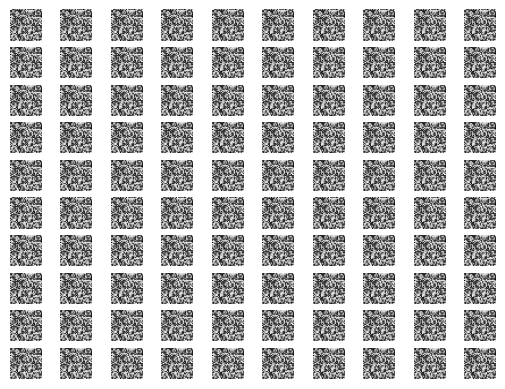

In [18]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

We are finally calling the train function with 100 random samples, 20 epochs, and 64 as batch size.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


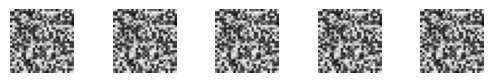

In [32]:
model = load_model('model_8433.h5')
latent_dim = 100
n_examples = 5
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2
save_plot(X, int(n_examples))

The generated images aren’t quite clear, right? Because we haven’t used Convolution layers in our model. Try it on your own and see the results.